# Implementierung eine Random Forest zur Erkennung von Werkzeugerkennung am Arbeitsplatz
Das Notebook beschreibt die Implementierung einer logistischen Regression für das klassifizieren von Bildern. Genauer gesagt, wollen wir herausfinden ob sich in einem Bild – beziehungsweise einem Kamerastream – ein Hammer befindet oder nicht.



## Aufbau:
Der Aufbau des Notebooks ist in drei grobe Teile geteilt. Zuerst wird der Datensatz eingelesen und vorbereitet. Anschlißend wird das Modell definiert und trainiert. Abschließend wird der trainierte Random Forest dazu eingesetzt neue Bilder aus einem Webcam Video zu kalssifizieren. 

### Abschnitt 1: Datensatz vorbereiten
Im ersten Teil des Notebooks wird der Datensatz vorbereitet. Hierzu wird ein [Dictonary](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/) angelegt. Anschließend kann mit dem Dictonary eine reshape Funktion aufgerufen werden um die Bildmatrizen in einen Vektor umzuwandeln wie auch schon in der Theorie im Use-Case [Klassifizieren mittels logistischer Regression](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/Logistische_Regression_fuer_Bildklassifizierung) besprochen wurde.  
### Abschnitt 2: Erstellen des Modells
In diesem Abschnitt wird das Modell mittels der [sklearn-Bibliothek](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) definiert. Dies ist auch der Abschnitt bei dem Parameter getuned werden können. Abschließend wird das Modell trainiert und getestet. Ebenso sieht man den Plot des Trainingsverlaufs. 
### Abschnitt 3: Webcam Implementierung
Im letzten Abschnitt wird das trainierte Modell eingesetzt. Der Random Forest predicted (klassifiziert) für jeden Frame des Kamerastreams ob sich im Bild ein Hammer befindet oder nicht. 




## Ordnerstruktur: 
Folgend ist die Ordnerstruktur aufgelistet. Wie auch in den anderen Klassifizierungs-Use-Cases dieser Art kann der Ordner Tool_Data mit einem eigenen Datensatz gefüllt werden. Die beiden Ordner _Hammer_ und _Workspace_ beinhalten die Fotos die den Datensatz ausmachen und zum trainieren herangezogen werden. 

Die Datei workspace_detection_{width}x{height}px.pkl ist eine Datei die im Laufe des Notebooks generiert wird und den Datensatz als [Dictonary](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/) abspeichert. Die Datei *.ipynb ist das Notebook selbst. 

Abschliesend gibt es noch die requirements.txt Datei. Diese kann eingesetzt werden um die benötigten Bibliotheken und Systemvorraussetzungen zu installieren. Eine (externe) Tutorial dazu findet man [hier](https://note.nkmk.me/en/python-pip-install-requirements/). 

1. demo
    - webcam_demo.gif
    - _demo images_
    
2. Tool_Data

    - Hammer _data images_
    - Workspace _data images_
    
3. [miniUsecases15_RandomForest.ipynb](./miniUsecase15_RandomForest.ipynb)
4. [workspace_detection_{width}x{height}px.pkl](./workspace_detection_{width}x{height}px.pkl)
5. [requirements.txt](./requirements.txt)



## Resultat:
Das unten angeführte GIF zeigt ein Beispielverhalten des Use-Cases. Eine Webcam ist über dem Arbeitsbereich positioniert und klassifiziert den Kamerastream. Im Camera-Stream direkt wird eingeblendet ob der Random Forest einen Hammer im Arbeitsbereich erkannt hat oder nicht. 

![alt text](demo/Random_Forest_Test.gif)



## Abschnitt 1: Importieren der generellen notwendigen Bibliotheken
Wir empfehlen die notwendigen Bibliotheken über die [requirements.txt](requirements.txt) Datei zu installieren. Das ermöglicht es, dass automatisch die richtigen Versionen installiert werden. Sollte eine Library nicht vorhanden sein, dann kann die häufig auch mit `pip3 <package-name\>` nachinstalliert werden. Sind alle libraries vorhanden, entsteht kein Output bei der nächsten Zelle. Im laufe des Notebooks werden weitere Bibliotheken benötigt. Diese werden erst in späteren Zellen aufgerufen um jeweils bei den entsprechenden Codesnipped zu garantieren, dass sie im Workspace geladen sind.

In [1]:
# data von miniUsecase11 logistic regression 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2grey
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning) 
warnings.simplefilter('ignore',UserWarning)

## Verschiedene Einstellungen um das Programm anzupassen

data_path: Muss zum Datensatz für das Trainieren des Modells geändert werden. z.B.: "/home/user/workspace/src/miniUsecase_15_Random_Forest/Tool_Data"

os.listdir(data_path): Zeigt die Ordner an, welche die Bilder für das Trainieren enthalten sollen. 

SIZE: definiert die größe des Bildes. Hier kann eingestellt werden wie sehr das Bild "verkleinert" werden soll. Ein guter Startpunkt ist meist _<original_image_size/rescaling\>_ wobei rescaling einfach als Skalar gewählt werden kann

In [2]:
# Hier kann der Pfad zum Datensatz und die Bildgröße geändert werden

data_path = os.getcwd() + "/data"
os.listdir(data_path) #im falle von dem Hammer-Beispiel werden hier Hammer und Workspace angezeigt
SIZE = 28

## Zusatzfunktion für das preperieren der Daten 
Diese funktion lädt alle Bilder in den Workspace (aus dem definierten Pfad) und macht foglende 2 Aktionen:
- Resize: Skaliert die Bilder entsprechend der Vorgabe
- Dictionary: Erstellt ein Dictionary mit Labels und Metadata (Datensatz für das Trainieren). Der output wird als _pickle file_ im Workspace abgespeichert.

Parameter: 
- src: gibt den Pfad zu den Daten an
- pklname: erstellt den Namen für die Pickle Datei
- include: Includiert als String List die beiden Klassen (Hammer, Workspace)
- width: gibt die größe der Bilder/Resize an

[Tutorial zum Implementieren von Dictionaries](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/)

In [3]:
# Libraries 
import joblib
from skimage.io import imread
from skimage.transform import resize


# Funktionsdefinition 
def resize_all(src, pklname, include, width = 150, height=None):
    height = height if height is not None else width #ERRORHANDLING
    
# definiert den Datansatz als Dictionary 
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   

    pklname = f"{pklname}_{width}x{height}px.pkl"

    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
 # itteriert über alle Bilder im Datensatz 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
# erstellt die Pickle file
        joblib.dump(data, pklname)

## Formatieren des Datensatzes
Hier wird die Hilfsfunktion aufgerufen, die für das erstellen des Datensatzes notwendig ist. Ebenso werden hier die Parameter übergeben. Zu beachten ist, dass hier nur _.jpg_ und _.png_ Bilder verarbeitet werden können. 

In [4]:
base_name = 'Fashion-MNIST'   # Name für die Beschreibung des Datensatzes
width = SIZE                        # Definierte Bildgröße übergeben (Zelle 2)
include = {'Dress', 'Pullover'}   # Ordner angeben
 
#FUNCTION CALL
resize_all(src=data_path, pklname=base_name, width=width, include=include) # Funktionsaufruf für das erstellen der pkl-Datei 

Pullover
Dress


## Informationen vom Datensatz
anbei werden bei korrektem erstellen des Dictionarys die Informationen dazu angezeigt. Diese werden über die Pickle Datei ausgelesen

In [5]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')    # Laden der Datei
print('Anzahl der gefundenen Daten: ', len(data['data']))   
print('keys: ', list(data.keys()))                          # Zeigt die einzelnen Komponenten  
print('Beschreibung: ', data['description'])                
print('Bild Form ', data['data'][0].shape)                  # Format anzeigen. Nützlich für das Reshapen nachher
print('Labels:', np.unique(data['label']))                  # Labels für die Klassifizierung
Counter(data['label'])                                      # Aufteilung anzeigen

Anzahl der gefundenen Daten:  11976
keys:  ['description', 'label', 'filename', 'data']
Beschreibung:  resized (28x28) images in rgb
Bild Form  (28, 28)
Labels: ['D' 'Pull']


Counter({'Pull': 5991, 'D': 5985})

## Datensatz Beispiel der beiden Klassen
Folgende Zelle lädt jeweils ein Bild/Klasse. Sollten hier nicht erwartete Bilder erscheinen muss der Datensatz überprüft werden.

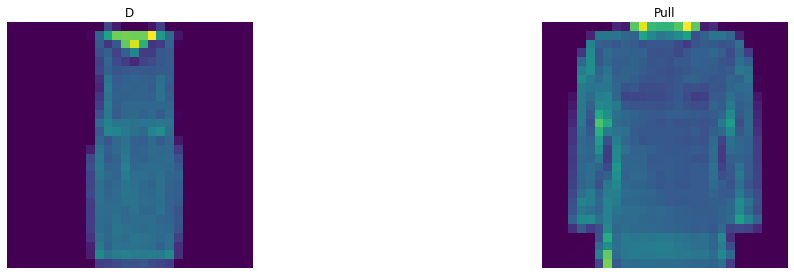

In [6]:
labels = np.unique(data['label'])           # Labels auslesen


# Matplot handling um Achsen zu erstellen
fig, axes = plt.subplots(1, len(labels))    # Plot definieren
fig.set_size_inches(15,4)                   # Größe
fig.tight_layout() 

# Generiert einen Plot mit einem Bild aus jeder Klasse
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

## Datensatz umformen
Die derzeitige Form eines eingelesenen Bildes ist <index, breite, höhe, schichten> mit index für die Anzahl der Elemente, Breite/Höhe gibt die Bildgröße in Pixel an und Schichten beschreibt die Art des Bildes (3 = RGB)

Um eine Klassifikation durchzuführen benötigt das System einen Vektor mit maximal 2 Dimensionen. Wir wollen einen Vektor mit <index, pixel_vektor>, wobei index gleich bleibt um mit den Labels (y-Vektor) übereinzustimmen. Der pixel_vektor ("Daten" entsprechend zum Index im X-Vektor) wird aus den restlichen Ebenen gebildet, um einen 1*n Vektor zu erhalten.  



In [7]:
X = np.array(data['data'])                                      # Einlesen der Bilder
print("Original Form: {}".format(X.shape))                      
x = X.reshape(X.shape[0], X.shape[1]* X.shape[2])   # Umformen auf die beschriebene Größe
print("Umgeformter Datensatz der Form: {}".format(x.shape))

y = np.array(data['label'])                                     # Einlesen der Labels
print("Der Index muss mit der Labels größe Übereinstimmen. \nLabels größe: {}".format(y.shape)) #Abgleichen ob die Form übereinstimmt 

Original Form: (11976, 28, 28)
Umgeformter Datensatz der Form: (11976, 784)
Der Index muss mit der Labels größe Übereinstimmen. 
Labels größe: (11976,)


# Abschnitt 2: Erstellen des Modells

## Random Forest - Model
(1) Datensatz in Trainings/Test Daten aufteilen <br>
(2) principal component analysis (PCA) definieren <br>
(3) Modell definieren <br>
(4) Genauigkeit auswerten <br>


Zum Einsatz kommt hier die sklearn Bibliothek welche ermöglicht ein bereits existierendes Model einzubinden und nur die Parameter zu definieren. Dadurch sind features wie Skalieren, PCA oder das Trainieren leicht umgesetzt. 

Weitere Dokumentation: </br>
[Guide zur Implementierung eines ML-Models](https://rpubs.com/Sharon_1684/454441)<br>
[Random Forest Parameter und Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### Aufteilen und Transformieren (PCA)
#### (1) Datensatz Teilen
Im ersten Abschnitt der folgenden Zelle wird der Datensatz in Trainings und Test Daten aufgeteilt. Das ermöglicht das trainieren und das anschließende testen des Models 

#### (2) Principal Component Analysis (PCA)
Im zweiten Teil wird eine PCA auf den Datensatz angewandt. Dies ermöglicht, dass nicht alle Pixel als Trainingsdaten herangezogen werden sonder nur herausstechende Features. 


In [8]:
# Aufteilen des Datensatzes (1)
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)


# (2) Skalieren
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)



#  PCA (2)
pca = PCA(.95)                                  # verwendet 95% der Komponenten und erstellen der "PCA-Instanz"
pca.fit(X_train)                                # PCA aufgrund von Datensatz auslegen
pca.n_components_                               
print(pca.n_components_)
X_train = pca.transform(X_train)                # PCA auf Datensatz anwenden
X_test = pca.transform(X_test)                  # PCA auf Test Daten anwenden
pd.Series(y_train).value_counts()               # Evaluieren der Verteilung der Daten

125


D       4196
Pull    4187
dtype: int64

#### (3) Modell definieren
In der folgenden Zelle wird der Random Forest Classifier definiert. Hierzu wird die RandomForestClassifier Library von der sklearn-Bibliothek eingefügt. 

##### Parameter:
max_depth: Die maximale Tiefe des Baums. 

random_state: Steuert sowohl die Zufälligkeit des Bootstrappings der Stichproben, die beim Erstellen von Bäumen verwendet werden (wenn bootstrap=True), als auch die Stichprobe der Merkmale, die bei der Suche nach der besten Aufteilung an jedem Knoten berücksichtigt werden (wenn max_features < n_features). Standardmäßig ist 0/None Eingestellt. 


n_estimators: "The number of trees in the forest." Standardmäßig sind 100 Eingestellt

Weitere Parameter: 
- criterion
- min_samples_splitint
- min_samples_leafint
- min_weight_fraction_leaffloat
- max_features
- max_leaf_nodesint
- n_jobsint


Mehr Infos zu weiteren [Parametern](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [9]:
from sklearn.ensemble import RandomForestClassifier                          # Library

rfc = RandomForestClassifier(max_depth=5, random_state=0, n_estimators = 10) # (3) Random Forest Modell definieren

rfc.fit(X_train, y_train)                                                    # Modell Trainieren

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=0)

### (4) Genauigkeit auswerten

In [10]:
y_pred = rfc.predict(X_test)                     # Prediction für den Test Datensatz
accuracy = accuracy_score(y_test, y_pred)        # Auswertung
print('Model accuracy: ', accuracy)              # Ausgabe der Genauigkeit

Model accuracy:  0.934873364876148


# Abschnitt 3: Webcam Implementierung
## Ausführung der Live erkennung
In der folgenden Zelle wird ein Kamerastream geöffnet und Frame für Frame eine Prediction durchgeführt. so wie es in dem Demo example auch passiert ist. Der unterschied hier ist lediglich, dass die Bilder nicht eingelesen werden über vorhandene Daten sondern dynamisch über die Kamera "generiert" werden.  


## Demo Zelle für das Ausführen der Prediction für 2 Bilder
Die folgende Zelle nimmt nun das trainierte Modell her und führt eine Prediction anhand zwei demo Bilder durch. Diese sind in dem Demo Ordner hinterlegt. Ziel ist es einmal einen Workspace und einmal einen Hammer zu erkennen. Ist dies nicht der Fall, ist es wahrscheinlich keine gute Vorraussetzung für die Webcam-Implementation und die Modell-Parameter sollten überarbeitet werden. 

In [11]:

# Einlesen und definieren der Bilder
demo1 = "demo/001.png"
demo2 = "demo/002.png"
width = SIZE
height = SIZE

# Vorbereiten der Bilder
im1 = imread(demo1)
im1 = resize(im1, (width, height))
im1 = im1.reshape(1 ,-1)
im1 = scaler.transform(im1)
im1 = pca.transform(im1)

im2 = imread(demo2)
im2 = resize(im2, (width, height))
im2 = im2.reshape(1 ,-1)
im2 = scaler.transform(im2)
im2 = pca.transform(im2)


# Prediction und Ausgabe für das erste Bild
y_new_prob  = rfc.predict_proba(im1)
y_new  = rfc.predict(im1)
print("Dress Example:")
print("Class: {}\t with Probability of: \t{} ".format(y_new[0], y_new_prob[0]))

# Prediction und Ausgabe für das zweite Bild
y_new_prob  = rfc.predict_proba(im2)
y_new  = rfc.predict(im2)
print("Pullover Example:")
print("Class: {}\t with Probability of: \t{} ".format(y_new[0], y_new_prob[0]))

Dress Example:
Class: D	 with Probability of: 	[0.59746495 0.40253505] 
Pullover Example:
Class: Pull	 with Probability of: 	[0.33113885 0.66886115] 


In [12]:

#libraries
from skimage.transform import resize
from sklearn.decomposition import PCA
import cv2
from IPython.display import clear_output


cv2.namedWindow('Prediction | press q to exit', 0)
i = 0
for filename in os.listdir("demo"):
    img = cv2.imread(os.path.join("demo/",filename), 0)
    img = resize(img, (width, height))
    if img is None:
        print(os.path.join("demo/",filename))
        break
    else: 
        # Bild aus einer Matrix in einen Vektor umformen 
        image = img.reshape(1 ,-1)

        # Bild an das Modell anpassen (Skalieren und PCA anwenden)
        image = scaler.transform(image)
        image = pca.transform(image)

        #Predict 
        y_new_prob  = rfc.predict_proba(image)
        y_new  = rfc.predict(image)

        # Wahrscheinlichkeit des Bildes (bei einer Klassifizierung) in Prozent umrechnen
        prob = y_new_prob[0]*100


        clear_output(wait=True)
        print("***************")
        i = i+1
        print("Example Image: {}".format(i))
        #Auswertung für die "live" Darstellung
        if (y_new == "D"):
            print("Dress")
            print("{:.2f}%".format(prob[0]))
        elif (y_new == "Pull"): 

            print("Pullover")
            print("{:.2f}%".format(prob[1]))
        else:
            print("Unknown Class: ({})".format(y_new))

        
        #Ausgabe 
        cv2.imshow('Prediction | press q to exit', img)
        #User Input für das beenden des Darstellen  
        if cv2.waitKey(1000) & 0xFF == ord('q'):    
            break


# Stream schließen und Window Handling

cv2.destroyAllWindows()

***************
Example Image: 24
Pullover
51.17%
